# cifar-10 training and prediction using tensorflow, simple stuff

## koshy george, kgeorge2@gmail.com

We use [tensorflow](https://www.tensorflow.org/) to train a convolutional neural net (CNN) net to classify [cifar-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. 

There are already enough examples out there to  show how this is done. Two examples are

1. [official tensorflow cifar turorial](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/models/image/cifar10)
2. [JeanDut's github page](https://github.com/jeandut/tensorflow-models)

We are not here attempting to get the highest accuracy in test images. The objective of this exercise is to have the code in a simplified manner, which does the training.

We first tried the [official tensorflow cifar turorial](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/models/image/cifar10). A beginner at solving image classification problem of [cifar-10](https://www.cs.toronto.edu/~kriz/cifar.html) need to get this done from basic knowledge of CNN and [tensorflow](https://www.tensorflow.org/). But most of the code [here](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/models/image/cifar10) employs knowledge of higher level tensorflow functionalities, which a beginner is only struggling to know. [JeanDut's github page](https://github.com/jeandut/tensorflow-models) prooved much more useful to us, when we were stuck. But what follows is mainly our implememtation of this from simple basic principles.

Also, our implementation here has got a few additional contributions, (though not necessarily have any direct bearing on either [tensorflow](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/models/image/cifar10) or deep learning), but, none the less on jupyter notebook technology.

1. Our main notebook document (that is this notebook) imports other notebooks which contian common code. Please see [here](http://jupyter-notebook.readthedocs.io/en/latest/examples/Notebook/Importing%20Notebooks.html). We use the following set of relative paths. In the example given below, *this_notebook.ipynb* imports *utils.ipynb* as a python module.
    * *this_notebook.ipynb*
    * *common*
        * *utils.ipynb*

2. We require [jupyter ipywidgets](https://github.com/ipython/ipywidgets) to be installed before running this notebook and we have written a small custom ipywidget to show incremental progress as training goes. [ipywidget](https://github.com/ipython/ipywidgets) is a small add-on to [jupyter](http://jupyter.org/) technology. You can easily pip install this component once you have installed [jupyter](http://jupyter.org/).



Let us import <code>common/utils.ipynb</code> as a python module. We first amend <code>sys.path</code> to include the relative path which houses the <code>utils.ipynb</code> notebook. We also import the module <code> load_notebooks.ipynb</code> which helps us in loading <code>utils.ipynb</code>.

In [1]:
from __future__ import division, print_function, absolute_import
#mechanism to dynamically include the relative path where utils.ipynb is housed to the module search path.
from inspect import getsourcefile
import os
import os.path
import sys
import time
import re
import cPickle
import urllib, tarfile
current_path = os.path.abspath(getsourcefile(lambda:0))
parent_dir = os.path.split(os.path.dirname(current_path))[0]
sys.path.insert(0, parent_dir)
#load_notebooks.py is a module which houses the mechanism to load other notebooks as a python module

import common.load_notebooks
import common.utils

importing Jupyter notebook from common/utils.ipynb


<IPython.core.display.Javascript object>

In [2]:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
DATA_URL = 'http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
def maybe_download_and_extract(dest_directory):
    """Download and extract the tarball from Alex's website."""
    if not os.path.exists(dest_directory):
        os.makedirs(dest_directory)
    filename = DATA_URL.split('/')[-1]
    filepath = os.path.join(dest_directory, filename)
    if not os.path.exists(filepath):
        def _progress(count, block_size, total_size):
            sys.stdout.write('\r>> Downloading %s %.1f%%' % (filename,
            float(count * block_size) / float(total_size) * 100.0))
            sys.stdout.flush()
        filepath, _ = urllib.urlretrieve(DATA_URL, filepath, _progress)
    print()
    statinfo = os.stat(filepath)
    print('Successfully downloaded', filename, statinfo.st_size, 'bytes.') 
    with tarfile.open(filepath, 'r:gz') as t:
        dataset_dir = os.path.join(dest_directory, t.getmembers()[0].name)
        t.extractall(dest_directory)
    
    return dataset_dir

dataset_dir = maybe_download_and_extract('./../data')
print(dataset_dir)


Successfully downloaded cifar-10-python.tar.gz 170498071 bytes.
./../data/cifar-10-batches-py


Given below  are the hyper parameters used. We use cifar-10 which consist of images categorized into 10 classes. So <code>n_classes</code> = 10. Our <code>batch_size</code>  which is the number of sample images in a mini-batch is 256. The input images are 3-channel (RGB) images ech of size <code>image_depth x image_height x image_width</code>, where <code>image_height</code> = 32, <code>image_width</code> = 32 and <code>image_depth</code>=3. Our <code>learning_rate</code> is 0.1. We do not employ any learnig rate decay. We use a <code>MomentumOptimizer</code>, with a momentum rate of 0.9. Once we train all images in  the training set, we repeat the training for <code>n_epoch</code>, where <code>n_epoch</code>=30. If epoch number <code>(0:n_epochs)</code> is divisible by <code>n_checkpoint_steps</code>, we save the checkpoint.

In [4]:
#hyper parameters
n_classes=10
batch_size=256
image_width=32
image_height=32
image_depth=3
learning_rate=0.1
n_epochs=30
#only the first 2000 samples is used for testing
n_test_samples=2000
n_checkpoint_steps=5

At the end of the loading of data and labels from the dataset, we expect the following

*  <code>train_all['data']</code> is an <code>numpy</code> ndarray of <code>dtype=numpy.float32</code> and  shape <code>(N_train, h, w, d)</code>, where <code>N_train</code>=number of images  in the training set, <code>h=image_height, w=image_width</code> and <code>d=image_depth</code>.

*  <code>train_all['labels']</code> is an <code>numpy</code> ndarray of <code>dtype=numpy.int32</code> and  shape = <code>(N_train,)</code>

*  <code>test_all['data']</code> is an <code>numpy</code> ndarray of <code>dtype=numpy.float32</code> and  shape <code>(N_test, h, w, d)</code>, where <code>N_test</code>=number of images  used for testing, <code>h=image_height, w=image_width</code> and <code>d=image_depth</code>.

*  <code>train_all['labels']</code> is an <code>numpy</code> ndarray of <code>dtype=numpy.int32</code> and  <code>shape = (N_test,)</code>
*  <code>N_test = n_test_samples</code>, (ie 2000) only the first 2000 images in the test set is used for testing.
* <code>train_all['data']</code>  and <code>test_all['data']</code>  are mean normalized across samples.

#### mean-normalization
We do not employ any dynamic data-augmentation (which can prevent overfitting). We do not crop the images to any smaller size.  The only transformation that we do is mean-normalization across the dataset. Please note that, the mean normalization is not per-image mean-normalization. We take the data-part (not labels-part) as an N x 3072 float array, and mean-normalize each of the 3072 elements across all images(ie N).




In [5]:

#regular expression that matches a datafile
r_data_file = re.compile('^data_batch_\d+')

#training and test datasets as numpy n-d arrays, 
#apropriate portions of which are ready to be fed to the placeholder variables
train_all={'data':[], 'labels':[]}
test_all={'data':[], 'labels':[]}


def unpickle(relpath):    
    with open(relpath, 'rb') as fp:
        d = cPickle.load(fp)
    return d

def transform_input(data=None, labels=None, h=-1, w=-1, d=-1):
    global image_width, image_height, image_depth
    assert(data.shape[1] == image_height*image_width*image_depth)
    assert(data.shape[0] == labels.shape[0])
    data = data.reshape([-1,image_depth, image_height, image_width])
    data = data.transpose([0, 2, 3, 1])
    data = data.astype(np.float32)
    return data, labels

def prepare_input(data=None, labels=None):
    global image_height, image_width, image_depth
    assert(data.shape[1] == image_height * image_width * image_depth)
    assert(data.shape[0] == labels.shape[0])
    #do mean normaization across all samples
    mu = np.mean(data, axis=0)
    mu = mu.reshape(1,-1)
    sigma = np.std(data, axis=0)
    sigma = sigma.reshape(1, -1)
    data = data - mu
    data = data / sigma
    is_nan = np.isnan(data)
    is_inf = np.isinf(data)
    if np.any(is_nan) or np.any(is_inf):
        print('data is not well-formed : is_nan {n}, is_inf: {i}'.format(n= np.any(is_nan), i=np.any(is_inf)))
    #data is transformed from (no_of_samples, 3072) to (no_of_samples , image_height, image_width, image_depth)
    #make sure the type of the data is no.float32
    data = data.reshape([-1,image_depth, image_height, image_width])
    data = data.transpose([0, 2, 3, 1])
    data = data.astype(np.float32)
    return data, labels

    #return transform_input(data=data, labels=labels, h=image_height, w=image_width, d=image_depth)


def load_and_preprocess_input(dataset_dir=None):
    assert(os.path.isdir(dataset_dir))
    global train_all, test_all
    trn_all_data=[]
    trn_all_labels=[]
    tst_all_data=[]
    tst_all_labels=[]
    #for loading train dataset, iterate through the directory to get matchig data file
    for root, dirs, files in os.walk(dataset_dir):
        for f in files:
            m=r_data_file.match(f)
            if m:
                relpath = os.path.join(root, f)
                d=unpickle(os.path.join(root, f))
                trn_all_data.append(d['data'])
                trn_all_labels.append(d['labels'])
    #concatenate all the  data in various files into one ndarray of shape
    #data.shape == (no_of_samples, 3072), where 3072=image_depth x image_height x image_width
    #labels.shape== (no_of_samples)
    trn_all_data, trn_all_labels = (np.concatenate(trn_all_data).astype(np.float32),
                                          np.concatenate(trn_all_labels).astype(np.int32)
                                        )
    
    #load the only test data set
    #use only the first n_test_samples samples for testing
    test_temp=unpickle(os.path.join(dataset_dir, 'test_batch'))
    tst_all_data=test_temp['data'][0:n_test_samples, :]
    tst_all_labels=test_temp['labels'][0:n_test_samples]
    tst_all_data, tst_all_labels =  (np.concatenate([tst_all_data]).astype(np.float32),
                                             np.concatenate([tst_all_labels]).astype(np.int32))
    #transform the test images in the same manner as the train images
                                                             
    train_all['data'], train_all['labels'] = prepare_input(data=trn_all_data, labels=trn_all_labels)
    test_all['data'], test_all['labels'] = prepare_input(data=tst_all_data, labels=tst_all_labels)
    
load_and_preprocess_input(dataset_dir=dataset_dir)
 
print('train_all: ', 'data: ', train_all['data'].shape, train_all['data'].dtype,  '  labels: ', train_all['labels'].shape, train_all['labels'].dtype)
print('test_all: ', 'data: ', test_all['data'].shape, test_all['data'].dtype,  '  labels: ', test_all['labels'].shape, test_all['labels'].dtype)

train_all:  data:  (50000, 32, 32, 3) float32   labels:  (50000,) int32
test_all:  data:  (2000, 32, 32, 3) float32   labels:  (2000,) int32


<code>init_weights</code> is a handy function that constructs a  tensorflow Variable from a set of parameters. We can use this to construct, weights and biases for our network used.

<code>wireup</code> accepts the data <code>X</code> as a placeholder and wire-up the model (neural net), returning the variable which is the final output.(logits)

<code>compute_loss</compute> computes the cross-entropy between the logits and the label-data

In [6]:

#kg: handy general initialization function
#
def init_weights(shape, init_method='xavier', seed=42, xavier_params = (None, None), const=0.0,  name='', stddev=0.05):
    assert(name)
    if init_method=='constant':
        return tf.get_variable(name, shape, initializer=tf.constant_initializer(const), dtype=tf.float32)
    elif init_method == 'uniform':
        return tf.Variable(tf.random_normal(shape, stddev=stddev, dtype=tf.float32, seed=seed), name=name)
    elif init_method == 'tnormal':
        return tf.get_variable(name, shape,  dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=stddev, dtype=tf.float32, seed=seed))
        #return tf.Variable(, name=name)
    elif init_method=='xavier':
        (fan_in, fan_out) = xavier_params
        low = -4*np.sqrt(6.0/(fan_in + fan_out))
        high = 4*np.sqrt(6.0/(fan_in + fan_out))
        return tf.Variable(tf.random_uniform(shape, minval=low, maxval=high, dtype=tf.float32, seed=seed), name=name)


def wireup(x, batch_size=256, n_classes=10, scope='dummy'):
    with tf.variable_scope(scope) as sc:
        #first convolutional layer
        weights_initializer_method='tnormal'
        c1 = init_weights(shape=[5,5,3, 64], init_method=weights_initializer_method, name='c1')
        conv1 = tf.nn.conv2d(x, c1, strides=[1,1,1,1], padding='SAME')
        b1 = init_weights(shape=[64], init_method='constant', name='b1')
        conv1 = tf.nn.relu(tf.nn.bias_add(conv1, b1), name='conv1')
        pool1 = tf.nn.max_pool(conv1, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1],
                         padding='SAME', name='pool1')
        norm1 = tf.nn.lrn(pool1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75,
                    name='norm1')
    
    
        #second convolutional layer
        c2 = init_weights(shape=[5,5,64, 64], init_method=weights_initializer_method, name='c2')
        conv2 = tf.nn.conv2d(norm1, c2, strides=[1,1,1,1], padding='SAME')
        b2 = init_weights(shape=[64], init_method='constant', name='b2', const=0.1)
        conv2 = tf.nn.relu(tf.nn.bias_add(conv2, b2), name='conv2')
        norm2 = tf.nn.lrn(conv2, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75,
                    name='norm2')
        pool2 = tf.nn.max_pool(norm2, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1],
                         padding='SAME', name='pool2')
    
        reshape = tf.reshape(pool2, [batch_size, -1])
        dim = reshape.get_shape()[1].value
        #first fully connected layer
        fc1= init_weights(shape=[dim, 384], init_method=weights_initializer_method, name='fc1')
        bc1= init_weights(shape=[384], init_method='constant', name='bc1', const=0.1)
        full1 = tf.nn.relu(tf.matmul(reshape, fc1) + bc1, name='full1')
       
        #second fully connected layer
        fc2= init_weights(shape=[384, 192], init_method=weights_initializer_method, name='fc2')
        bc2= init_weights(shape=[192], init_method='constant', name='bc2', const=0.1)
        full2 = tf.nn.relu(tf.matmul(full1, fc2) + bc2, name='full2')
           
        #output layer       
        last = init_weights(shape=[192, n_classes], init_method=weights_initializer_method, name='last')
        b_last = init_weights(shape=[n_classes], init_method='constant', name='b_last')
        logits = tf.add(tf.matmul(full2, last), b_last, name='final')
    return logits

def compute_loss(logits, labels):
    print('compute_loss: {lg}, {lb}'.format(lg=logits.get_shape(), lb=labels.get_shape()))
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
      logits, labels, name='cross_entropy_per_example')
    cross_entropy_mean = tf.reduce_mean(cross_entropy, name='cross_entropy')
    return cross_entropy_mean
    
    

#### GUI support for progress display
For displaying progress as an incrementally updating matplotlib plot, we employ the custom [ipywidget](https://github.com/ipython/ipywidgets) , defined at <code>common/utils.ipynb</code> called <code>ProgressImageWidget</code>. We need two graphs, one for plotting training loss acros epoch-s and the other for plotting accuracy of training and test data across epochs. We enclose the two <code>ProgressImageWidget</code>-s in a [ipywidget](https://github.com/ipython/ipywidgets)  VBox.

<code>ProgressImageWidget</code> will display any image assigned to its <code>value</code>, if the image is a [datauri](https://en.wikipedia.org/wiki/Data_URI_scheme) string. 

<code>
p=common.utils.ProgressImageWidget()
display(p)
</code>


..., lots of stuff


Now if if you assign the value element of <code>p</code> to some new image content, the widget displayed by the display  call above, will now have the new image content.
<code>
p.value = new_image_content_as_png_dataurl
</code>




In [7]:
from IPython.display import display
import ipywidgets as widgets
p_loss=common.utils.ProgressImageWidget()
p_acc=common.utils.ProgressImageWidget()
top_level=widgets.VBox(children=[p_loss, p_acc])
display(top_level)

#### GUI support for progress display, contd

Now for constructing the [datauri](https://en.wikipedia.org/wiki/Data_URI_scheme), which shows the progress graph, we employ another helper class called <code>Plotter</code> defined in <code>common/utils.ipynb</code>. We can construct a plotter with <code>xlabel, ylabel</code> and <code>title</code> parameters. An instance of a potter class, will return a png-datauri when the <code>plotter.plot()</code> is called.

We can also add many channels to the plot. For each channel we must supply an upperboumd on the number of samples that will be added to the channel. See <code>Plotter.add_channel</code>. All the channels will be shown on the same plot.

We should add as many samples to each channel as we please and if you call <code>plotter.plot()</code>, a pong datauri containing the plot will be returned.



In [8]:

#for displaying the training loss
plotter_loss = common.utils.Plotter(xlabel='no. of epochs', ylabel='loss', title='epochs')
plotter_loss.add_channel(num_samples=n_epochs, channel_name='train_loss', legend='train_loss')

#for displaying the training and test accuracy, in the sample plot
plotter_acc = common.utils.Plotter(xlabel='no. of epochs', ylabel='acc', title='epochs')
plotter_acc.add_channel(num_samples=n_epochs, channel_name='train_acc',legend='train_acc')
plotter_acc.add_channel(num_samples=n_epochs, channel_name='test_acc', legend='test_acc')
  

In [9]:

with tf.Graph().as_default():
    X = tf.placeholder(tf.float32, shape=(batch_size, image_height, image_width, image_depth))
    y = tf.placeholder(tf.float32, shape=(batch_size, 10))
    
    global_step = tf.Variable(0, trainable=False)
    logits=wireup(X, batch_size=batch_size, n_classes=10, scope='train')
    loss = compute_loss(logits, y)
    optimizer=tf.train.MomentumOptimizer(learning_rate,0.9).minimize(loss,global_step) 
    train_prediction = tf.nn.softmax(logits)
    accuracy_1 = tf.equal(tf.argmax(train_prediction, 1), tf.argmax(y, 1))
    accuracy=tf.reduce_mean(tf.cast(accuracy_1,tf.float32),0)
    
    init = tf.initialize_all_variables()
    n_batches_train = int(train_all['labels'].shape[0]//batch_size)
    n_batches_test = int(test_all['labels'].shape[0]//batch_size)
    
    def checkpoint():
        global dataset_dir
        dataset_name = os.path.split(dataset_dir)[1]
        if not os.path.isdir(os.path.join(dataset_dir, 'out')):
            os.makedirs(os.path.join(dataset_dir, 'out'))
        loss_fig_path= os.path.join(dataset_dir, 'out', '%s_train_loss.png' % dataset_name)
        acc_fig_path= os.path.join(dataset_dir, 'out', '%s_acc.png' % dataset_name)
        plotter_loss.plot_and_save_fig(savepath=loss_fig_path)
        plotter_acc.plot_and_save_fig(savepath=acc_fig_path)
        
    def all_batches_run_train(n_batches, data=None, labels=None):
        sum_all_batches_loss =0
        sum_all_batches_acc=0
        sum_n_samples=0
        for b in xrange(n_batches):            
                offset = b * batch_size
                batch_data = data[offset : offset+batch_size, :, :, :]
                n_samples = batch_data.shape[0]
                batch_labels = labels[offset: offset+batch_size]
                batch_labels = (np.arange(n_classes) == batch_labels[:, None]).astype(np.float32)
                feed_dict = {X: batch_data, 
                             y: batch_labels}
                _, loss_value, a = sess.run([optimizer, loss, accuracy], feed_dict=feed_dict)
                sum_all_batches_loss += loss_value * n_samples
                sum_all_batches_acc += a * n_samples
                sum_n_samples += n_samples
                if(n_samples != batch_size):
                    print('n_samples =%d' % n_samples)
        return sum_all_batches_loss/sum_n_samples, sum_all_batches_acc/sum_n_samples
    
    def all_batches_run_test(n_batches, data=None, labels=None):
        sum_all_batches_acc=0
        sum_n_samples=0
        for b in xrange(n_batches):
                offset = b * batch_size
                batch_data = data[offset : offset+batch_size, :, :, :]
                n_samples = batch_data.shape[0]
                batch_labels = labels[offset: offset+batch_size]
                batch_labels = (np.arange(n_classes) == batch_labels[:, None]).astype(np.float32)
                feed_dict = {X: batch_data, 
                             y: batch_labels}
                a = sess.run([accuracy], feed_dict=feed_dict)
                sum_all_batches_acc += a[0] * n_samples
                sum_n_samples += n_samples
                if(n_samples != batch_size):
                    print('n_samples =%d' % n_samples)
        return sum_all_batches_acc/sum_n_samples
                    
    with tf.Session() as sess:
        sess.run(init)
        print('starting training')
        
        
        for e in xrange(n_epochs):
            
            start_time = time.time()
            
            sum_loss_train=0
            sum_samples_train =0
            sum_acc_train=0
            n_data = train_all['data'].shape[0]
            
            perm = np.random.permutation(n_data)
            permuted_data = train_all['data'][perm,:, :, :]
            permuted_labels = train_all['labels'][perm]
            
            test_data = test_all['data']
            test_labels = test_all['labels']
            
            mean_loss_per_sample_train, accuracy_per_sample_train=all_batches_run_train(n_batches_train, data=permuted_data, labels=permuted_labels)
            accuracy_per_sample_test=all_batches_run_test(n_batches_test, data=test_data, labels=test_labels)
     
            plotter_loss.add_sample( e, mean_loss_per_sample_train , channel_name='train_loss')
            plotter_acc.add_sample( e, accuracy_per_sample_train, channel_name='train_acc')
            plotter_acc.add_sample( e, accuracy_per_sample_test, channel_name='test_acc')
            sum_acc_test=0
            sum_samples_test=0
            p_loss.value = plotter_loss.plot()
            p_acc.value = plotter_acc.plot()
            duration = time.time() - start_time
            if (e% n_checkpoint_steps) == 0:
                print('loss for epoch {e}, train_loss={l},  test-accuracy={a},  time={t}'.format(e=e, l=mean_loss_per_sample_train, a=accuracy_per_sample_test, t=duration))
                checkpoint()
                
            

compute_loss: (256, 10), (256, 10)
starting training
loss for epoch 0, train_loss=2.05103909725,  test-accuracy=0.401785714286,  time=37.4400861263
loss for epoch 5, train_loss=1.05417020168,  test-accuracy=0.620535714286,  time=36.5776240826
loss for epoch 10, train_loss=0.858339747099,  test-accuracy=0.667410714286,  time=36.4527468681
loss for epoch 15, train_loss=0.759336643188,  test-accuracy=0.641183035714,  time=36.4866271019
loss for epoch 20, train_loss=0.696488400759,  test-accuracy=0.654017857143,  time=36.4517228603
loss for epoch 25, train_loss=0.642553326258,  test-accuracy=0.651227678571,  time=36.4264109135


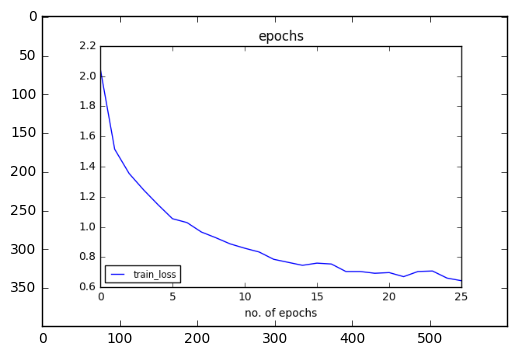

In [13]:

%matplotlib inline

from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

dataset_name = os.path.split(dataset_dir)[1]
pil_im = Image.open(os.path.join(dataset_dir, 'out', '%s_train_loss.png' % dataset_name))
imshow(np.asarray(pil_im))

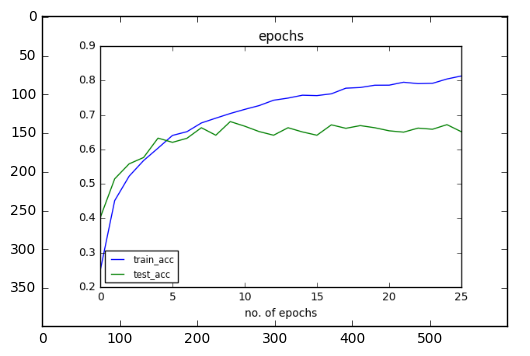

In [14]:


pil_im = Image.open(os.path.join(dataset_dir, 'out', '%s_acc.png' % dataset_name))
imshow(np.asarray(pil_im))